使用的设备: cuda

>>> 开始训练 GATv2 (Heads=4, Weights=0.3:0.7) ...
Epoch 020 | Loss: 0.2536 | Train F1: 0.7163
Epoch 040 | Loss: 0.1966 | Train F1: 0.7708
Epoch 060 | Loss: 0.1606 | Train F1: 0.8061
Epoch 080 | Loss: 0.1438 | Train F1: 0.8280
Epoch 100 | Loss: 0.1309 | Train F1: 0.8421
Epoch 120 | Loss: 0.1232 | Train F1: 0.8446
Epoch 140 | Loss: 0.1158 | Train F1: 0.8576
Epoch 160 | Loss: 0.1124 | Train F1: 0.8641
Epoch 180 | Loss: 0.1056 | Train F1: 0.8694
Epoch 200 | Loss: 0.1024 | Train F1: 0.8779

✅ GATv2 最终结果:
🔴 F1-Score:  0.5180
🔴 Recall:    0.6925
🔴 Precision: 0.4137


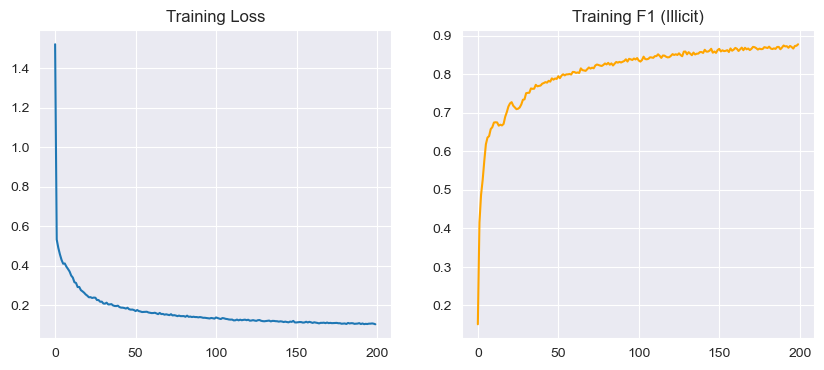

In [1]:
import torch
import torch.nn.functional as F
from torch_geometric.nn import GATv2Conv
from sklearn.metrics import f1_score, recall_score, precision_score
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

# 设置设备
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"使用的设备: {device}")

# 1. 加载数据 (记得 weights_only=False)
data = torch.load('../data/processed/elliptic_pyg.pt', weights_only=False)
data = data.to(device)

# 2. 定义 GAT 模型 (使用更强的 GATv2)
class GAT(torch.nn.Module):
    def __init__(self, in_channels, hidden_channels, out_channels, heads=4):
        super(GAT, self).__init__()

        # Layer 1: 多头注意力
        # concat=True: 输出维度 = hidden_channels * heads
        self.conv1 = GATv2Conv(in_channels, hidden_channels, heads=heads, concat=True)

        # Layer 2: 输出层
        # 输入维度需要乘以头数
        self.conv2 = GATv2Conv(hidden_channels * heads, out_channels, heads=1, concat=False)

    def forward(self, x, edge_index):
        # 保存原始特征用于 Residual
        identity = x

        # Layer 1
        x = self.conv1(x, edge_index)
        x = F.elu(x) # GAT 通常使用 ELU 激活函数
        x = F.dropout(x, p=0.6, training=self.training) # 提高 Dropout 到 0.6

        # Layer 2
        x = self.conv2(x, edge_index)

        return x

# 3. 训练配置
model = GAT(data.num_features, 64, 2, heads=4).to(device) # 64*4 = 256维
optimizer = torch.optim.Adam(model.parameters(), lr=0.005, weight_decay=5e-4)

# 使用你的新权重 [0.3, 0.7]
manual_weights = torch.tensor([0.3, 0.7]).to(device)
criterion = torch.nn.CrossEntropyLoss(weight=manual_weights)

print(f"\n>>> 开始训练 GATv2 (Heads=4, Weights=0.3:0.7) ...")

history = {'loss': [], 'f1': []}

for epoch in range(200): # 训练 200 轮
    model.train()
    optimizer.zero_grad()
    out = model(data.x, data.edge_index)
    loss = criterion(out[data.train_mask], data.y[data.train_mask])
    loss.backward()
    optimizer.step()

    # 记录
    pred = out.argmax(dim=1)
    f1 = f1_score(data.y[data.train_mask].cpu(), pred[data.train_mask].cpu(), pos_label=1)
    history['loss'].append(loss.item())
    history['f1'].append(f1)

    if (epoch+1) % 20 == 0:
        print(f"Epoch {epoch+1:03d} | Loss: {loss.item():.4f} | Train F1: {f1:.4f}")

# 4. 最终评估
model.eval()
with torch.no_grad():
    out = model(data.x, data.edge_index)
    pred = out.argmax(dim=1)

    y_true = data.y[data.test_mask].cpu().numpy()
    y_pred = pred[data.test_mask].cpu().numpy()

    f1 = f1_score(y_true, y_pred, pos_label=1)
    rec = recall_score(y_true, y_pred, pos_label=1)
    prec = precision_score(y_true, y_pred, pos_label=1)

    print(f"\n✅ GATv2 最终结果:")
    print(f"🔴 F1-Score:  {f1:.4f}")
    print(f"🔴 Recall:    {rec:.4f}")
    print(f"🔴 Precision: {prec:.4f}")

# 5. 绘制训练曲线
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history['loss'], label='Loss')
plt.title('Training Loss')
plt.subplot(1, 2, 2)
plt.plot(history['f1'], color='orange', label='Train F1')
plt.title('Training F1 (Illicit)')
plt.show()